In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Optional: Try importing imblearn for SMOTE
try:
    from imblearn.over_sampling import SMOTE
    imblearn_available = True
except ImportError:
    imblearn_available = False
    print("imblearn not found. Skipping SMOTE; using original imbalanced data.")

# Verify NumPy and scikit-learn versions
print(f"NumPy version: {np.__version__}")
try:
    from sklearn import __version__ as sklearn_version
    print(f"scikit-learn version: {sklearn_version}")
except ImportError:
    print("scikit-learn not found. Please ensure it is installed.")
    exit(1)

# Load dataset (replace with your path to creditcard.csv)
try:
    data = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("Error: creditcard.csv not found. Please provide the correct path.")
    exit(1)

# Preprocessing
# Check for missing values
print("Missing values:\n", data.isnull().sum())


NumPy version: 1.26.4
scikit-learn version: 1.5.2
Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


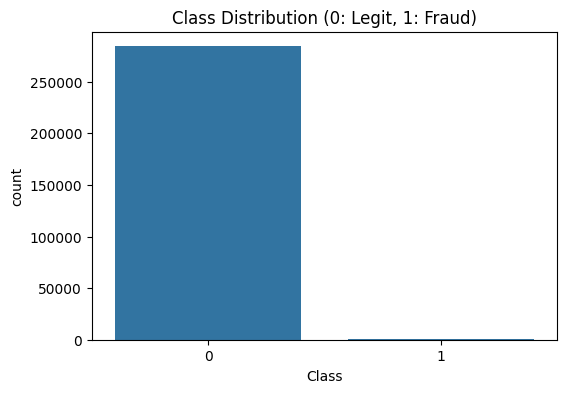

Fraud proportion: 0.0017


In [3]:
# Scale 'Amount' and 'Time' to have mean 0, std 1
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data['Time_scaled'] = scaler.fit_transform(data[['Time']])
data = data.drop(['Amount', 'Time'], axis=1)

# Features (X) and labels (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.show()
print(f"Fraud proportion: {y.mean():.4f}")

In [4]:
X_eval = X
y_eval = y
if imblearn_available:
    try:
        # Apply SMOTE to create synthetic frauds (10% fraud ratio)
        smote = SMOTE(sampling_strategy=0.1, random_state=42)
        X_eval, y_eval = smote.fit_resample(X, y)
        print(f"SMOTE applied. New fraud proportion: {y_eval.mean():.4f}")
    except Exception as e:
        print(f"SMOTE failed: {e}. Using original imbalanced data.")
else:
    print("No resampling applied (imblearn not available).")

SMOTE applied. New fraud proportion: 0.0909


In [5]:
# 1. Isolation Forest
# Builds 100 random trees to isolate anomalies
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_forest.fit(X)  # Train on original data (unsupervised)
y_pred_iso = iso_forest.predict(X)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # -1: anomaly (fraud), 1: normal (legit)
iso_scores = -iso_forest.decision_function(X_eval)  # Anomaly scores

# 2. One-Class SVM
# Learns a boundary around normal data
oc_svm = OneClassSVM(kernel='rbf', nu=0.0017)
oc_svm.fit(X)
y_pred_svm = oc_svm.predict(X)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
svm_scores = -oc_svm.decision_function(X_eval)




In [6]:
# Evaluation
models = {
    'Isolation Forest': (y_pred_iso, iso_scores),
    'One-Class SVM': (y_pred_svm, svm_scores),
}




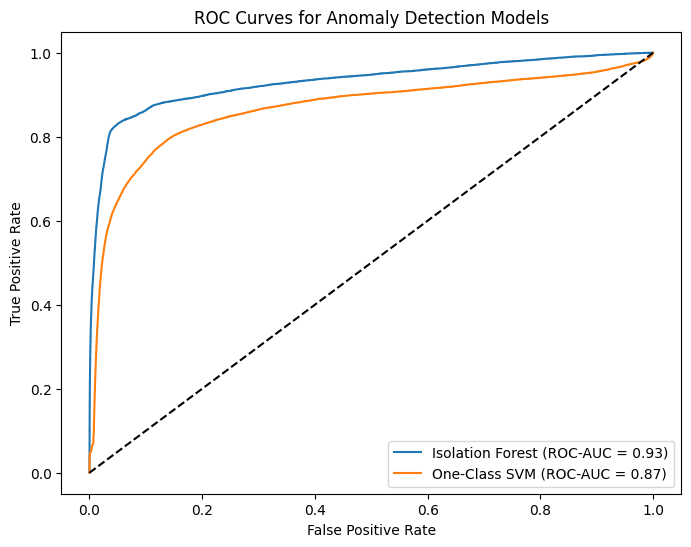

In [8]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, (y_pred, scores) in models.items():
    fpr, tpr, _ = roc_curve(y_eval, scores)
    roc_auc = roc_auc_score(y_eval, scores)
    plt.plot(fpr, tpr, label=f'{name} (ROC-AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Models')
plt.legend()
plt.show()